## Parameter Estimation Example
This example is from the [computational appendix](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/web-appendix.pdf) of James Rawlings [reactor design book](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/). The code for the example in octave is in this [location](https://github.com/rawlings-group/paresto/blob/master/examples/green_book/ABC.m). The octave version uses a more general parameter estimation routine [paresto](https://github.com/rawlings-group/paresto) written using CasADi. Here, I have attempted to recreate the example from scratch as a way to learn CasADi.

In [1]:
from casadi import *
import numpy as np
import pandas as pd
from scipy import linalg
from scipy.stats import chi2, f
import matplotlib.pyplot as plt

In [2]:
# read data
data_df = pd.read_csv('ABC_data.csv')
data_df.head()

,t,ca,cb,cc
0,0.000,0.957,-0.031,-0.015
1,0.263,0.557,0.330,0.044
2,0.526,0.342,0.512,0.156
3,0.789,0.224,0.499,0.310
4,1.053,0.123,0.428,0.454


In [3]:
t_exp = data_df['t'].values
ca_exp = data_df['ca'].values
cb_exp = data_df['cb'].values
cc_exp = data_df['cc'].values

In [4]:
# Define concentration variables
cA = MX.sym('cA')
cB = MX.sym('cB')
cC = MX.sym('cC')

In [5]:
x = vertcat(cA, cB, cC)
x

MX(vertcat(cA, cB, cC))

In [6]:
# Define rate constants
k1 = MX.sym('k1')
k2 = MX.sym('k2')
p = vertcat(k1, k2)
p

MX(vertcat(k1, k2))

In [7]:
# Define rates for ODE
r1 = k1 * cA
r2 = k2 * cB
dcA = -r1
dcB = r1 - r2
dcC = r2

In [8]:
ode_rhs = vertcat(dcA, dcB, dcC)
ode_rhs

MX(@1=(k1*cA), @2=(k2*cB), vertcat((-@1), (@1-@2), @2))

In [9]:
ode = {'x': x, 'p': p, 'ode': ode_rhs}

In [10]:
# times when experimental data is available
t_exp

array([0.   , 0.263, 0.526, 0.789, 1.053, 1.316, 1.579, 1.842, 2.105,
       2.368, 2.632, 2.895, 3.158, 3.421, 3.684, 3.947, 4.211, 4.474,
       4.737, 5.   ])

In [11]:
# create the sum of square errors function
tprev = 0.0
x0 = [1.0, 0.0, 0.0]
p = vertcat(k1, k2)
ssq = 0
for (i, t) in enumerate(t_exp[1:]):
    tdel = t - tprev
#    print(i, t, tdel)
    F = integrator('F','cvodes',ode,{'tf':tdel})
    res = F(x0 = x0, p = p)
    x0 = res['xf']
    tprev = t
    ssq = ssq + (res['xf'][0] - ca_exp[i + 1])**2 + (res['xf'][1] - cb_exp[i + 1])**2 + (res['xf'][2] - cc_exp[i + 1])**2

In [12]:
# Evaluate sum of squares at a particular value of k1,k2
ssqfn = Function('ssqfn', [p], [ssq])
ssqfn([0.5, 3])

DM(2.78363)

In [13]:
ssq

MX(@1=vertcat(k1, k2), @2=F([1, 0, 0], @1, 0x1, 0x1, 0x1, 0x1){0}, @3=F(@2, @1, 0x1, 0x1, 0x1, 0x1){0}, @4=F(@3, @1, 0x1, 0x1, 0x1, 0x1){0}, @5=F(@4, @1, 0x1, 0x1, 0x1, 0x1){0}, @6=F(@5, @1, 0x1, 0x1, 0x1, 0x1){0}, @7=F(@6, @1, 0x1, 0x1, 0x1, 0x1){0}, @8=F(@7, @1, 0x1, 0x1, 0x1, 0x1){0}, @9=F(@8, @1, 0x1, 0x1, 0x1, 0x1){0}, @10=F(@9, @1, 0x1, 0x1, 0x1, 0x1){0}, @11=F(@10, @1, 0x1, 0x1, 0x1, 0x1){0}, @12=F(@11, @1, 0x1, 0x1, 0x1, 0x1){0}, @13=F(@12, @1, 0x1, 0x1, 0x1, 0x1){0}, @14=F(@13, @1, 0x1, 0x1, 0x1, 0x1){0}, @15=F(@14, @1, 0x1, 0x1, 0x1, 0x1){0}, @16=F(@15, @1, 0x1, 0x1, 0x1, 0x1){0}, @17=F(@16, @1, 0x1, 0x1, 0x1, 0x1){0}, @18=F(@17, @1, 0x1, 0x1, 0x1, 0x1){0}, @19=F(@18, @1, 0x1, 0x1, 0x1, 0x1){0}, @20=F(@19, @1, 0x1, 0x1, 0x1, 0x1){0}, ((((((((((((((((((((((((((((((((((((((((((((((((((((((((sq((@2[0]-0.557))+sq((@2[1]-0.33)))+sq((@2[2]-0.044)))+sq((@3[0]-0.342)))+sq((@3[1]-0.512)))+sq((@3[2]-0.156)))+sq((@4[0]-0.224)))+sq((@4[1]-0.499)))+sq((@4[2]-0.31)))+sq((@5[0]-0.123)))+sq(

In [91]:
# function to calcuate hessian of sum of squares with respect to p = (k1, k2)
ssqfn_hess_calc = hessian(ssqfn(p), p)
ssqfn_hess = Function('ssqfn_hess', [p], [ssqfn_hess_calc[0]])

In [92]:
# NLP declaration
nlp = {'x': p,'f': ssq};

# Solve using IPOPT
solver = nlpsol('solver','ipopt',nlp)
res = solver(x0=[0.5, 3])


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [93]:
# Solution
p_est = res['x'].full().T
p_est

array([[2.01906606, 0.99297368]])

In [94]:
## calculate covariance matrix

# number of estiamted parameters
n_est = 2
# number of data points
n_data = len(t_exp) * 3


# hessian
H_sol = ssqfn_hess(p_est)
# mean sum of squares
msq = res['f'] / (n_data - n_est)
print("mean sum of squares", msq)

print("Covariance matrix")
cov = 2 * msq * linalg.inv(H_sol)
print(cov)

mean sum of squares 0.000396938
Covariance matrix

[[0.00214782, -0.000326089], 
 [-0.000326089, 0.000285287]]


In [95]:
# Confidence interval (deviation from estimate)
np.sqrt(np.diag(cov)) * np.sqrt(n_est * f.ppf(0.95, n_est, n_data - n_est))

array([0.11643342, 0.0424346 ])

In [96]:
# Simulate again with estimated rate constants
tgrid = np.linspace(0, 5, 100)
F = integrator('F','cvodes',ode,{'tf':5, 'grid': tgrid, 'output_t0' : True})
res = F(x0 = [1.0, 0.0, 0.0], p = res['x'].full().T)

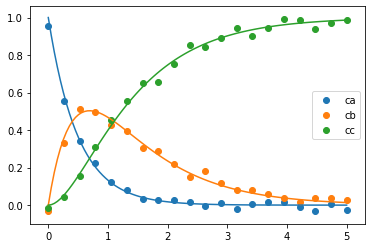

In [97]:
# plot prediction and data
xsol = res['xf'].full().T
fig, ax = plt.subplots()
ax.plot(tgrid, xsol)
ax.scatter(t_exp, ca_exp, label = 'ca')
ax.scatter(t_exp, cb_exp, label = 'cb')
ax.scatter(t_exp, cc_exp, label = 'cc')
ax.legend()